# Описание набора данных
---


Задание выполнено на основе известного датасета с ресурса Kaggle.
Задача является задачей бинарной классификации, так как для каждого из наблюдений (т.е. для пассажира) нам нужно предсказать, выжил он или нет (для целевой переменной "Survived" существует только два значения: 1 и 0 соответственно). Попробуем применить известные методы классификации: k-NN, логистическую регрессию, а затем сравним их эффективность.

Даны две таблицы (выборки) - тренировочная и тестовая - с данными о пассажирах Титаника в формате .csv. Каждая строка = признаковое описание одного из пассажиров. Для тестовой выборки нужно предсказать, выжил ли пассажир - целевая переменная (колонка, target) "Survived".


*   **train.csv** - данные для обучения модели, содержат колонку "Survived"
*   **test.csv** - данные для которых нужно сделать предсказание, колонки с ответом не содержат



# Загрузка и предварительная обработка данных
---


Импортируем необходимые библиотеки:

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [97]:
train = pd.read_csv('/content/sample_data/train.csv', index_col='PassengerId')
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [98]:
test = pd.read_csv('/content/sample_data/test.csv', index_col='PassengerId')
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Признаки (колонки, переменные, атрибуты) датасета:**


- **Pclass** - класс, в котором плыл пассажир, passenger class 


- **SibSp** - количество братьев-сестёр/супругов на борту, sibling/spouse


- **Parch** - количество детей/родителей пассажира на борту, parent/children


- **Cabin** - номер каюты 

и т.д.

Оценим качество данных:

In [99]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [100]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


Судя по всему, нам не пригодятся данные об именах пассажиров, номерах билетов, и номерах **Cabin** (кают). Удалим эти столбцы.
Заполним пропущенные значения для категориальных переменных модой по колонке, для количественных - медианой.

In [101]:
useless_col = ['Name', 'Ticket', 'Cabin']

train = train.drop(columns=useless_col)
test = test.drop(columns=useless_col)

In [102]:
train['Age'].fillna(train['Age'].median(), inplace = True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace = True)

test['Age'].fillna(train['Age'].median(), inplace = True)
test['Fare'].fillna(train['Fare'].median(), inplace = True)

In [103]:
# Проверим данные
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


In [104]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 26.1+ KB


Из приведенного ниже графика видно, что большая часть погибших - мужчины в возрасте от 16 до 40 лет. И что большая часть выживших - женщины.

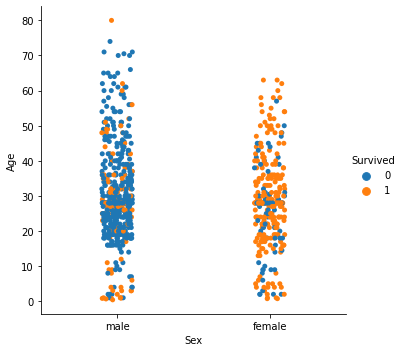

In [105]:
sns.catplot(data=train, x='Sex', y='Age', hue='Survived', kind='strip');

Кроме того, большая часть мужчин - бедные из 3 класса.

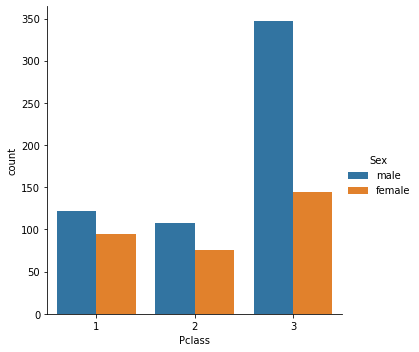

In [106]:
sns.catplot(data=train, x='Pclass', hue='Sex', kind='count');

Также заметим, что выживаемость зависит от количества членов семьи. Здесь это параметр "супруги/братья и сёстры" - **SibSp** и параметр "дети/родители" - **Parch**.

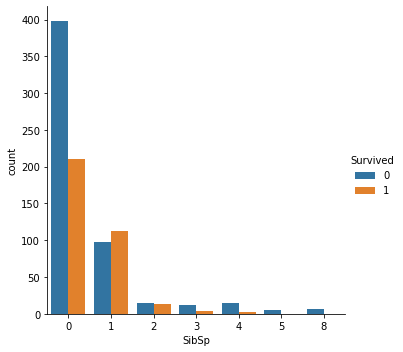

In [107]:
sns.catplot(data=train, x='SibSp', hue='Survived', kind='count');

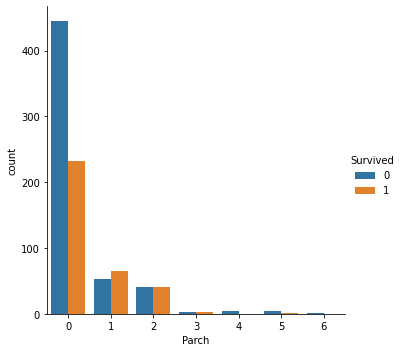

In [108]:
sns.catplot(data=train, x='Parch', hue='Survived', kind='count');

In [109]:
# Добавим признак "TravelAlone", для простоты, так как оба признака
# SibSp и Parch похожим образом зависят от выживаемости, а для модели не хорошо,
# когда некоторые признаки подозревают в сильной зависимости между друг другом. 
train_data = train.copy()
train_data['TravelAlone']=np.where((train_data["SibSp"] + train_data["Parch"]) > 0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

In [110]:
# Преобразуем категориальные значения в числовые в столбцах Pclass, Embarked
# и Sex. Так как пол определяется бинарно, второй столбец не нужен. По этой же
# причине в дальнейшем в тренировочную выборку не попадёт один из портов и один
# из классов.
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)

final_train = training
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
PassengerId,,,,,,,,,,,
1,0,22.0,7.2500,0,0,0,1,0,0,1,1
2,1,38.0,71.2833,0,1,0,0,1,0,0,0
3,1,26.0,7.9250,1,0,0,1,0,0,1,0
4,1,35.0,53.1000,0,1,0,0,0,0,1,0
5,0,35.0,8.0500,1,0,0,1,0,0,1,1


In [111]:
# Аналогичным образом поступим с тестовыми данными.
test_data = test.copy()
test_data['TravelAlone']=np.where((test_data["SibSp"] + test_data["Parch"]) > 0, 0, 1)
test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

In [112]:
testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)

final_test = testing
final_test.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
PassengerId,,,,,,,,,,
892,34.5,7.8292,1,0,0,1,0,1,0,1
893,47.0,7.0000,0,0,0,1,0,0,1,0
894,62.0,9.6875,1,0,1,0,0,1,0,1
895,27.0,8.6625,1,0,0,1,0,0,1,1
896,22.0,12.2875,0,0,0,1,0,0,1,0


# Построение модели

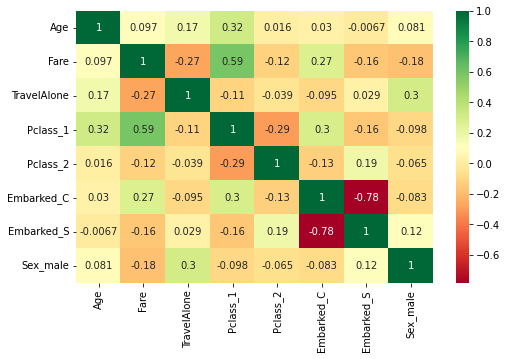

In [113]:
selected_features = ['Age', 'Fare', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male']
X = final_train[selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

Так как результаты тестовой выборки нам неизвестны (мы должны их предсказать), попробуем разделить тренировочный набор данных искусственно и сделать из него нужные нам выборки, чтобы не обучаться на тестовых данных. Затем оценим эффективность двух классификаторов - логистической регрессии и k-NN.

In [114]:
X = final_train[selected_features]
y = final_train['Survived']

# Размер тестовой выборки 0.2.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Проверим характеристики модели LogisticRegression.
logreg = LogisticRegression(max_iter=175)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

# Индекс, обозначающий границу на графике ROC, где зачение TruePositiveRate > 0.95
idx = np.min(np.where(tpr > 0.95))

Train/Test split results:
LogisticRegression accuracy is 0.782
LogisticRegression auc is 0.836


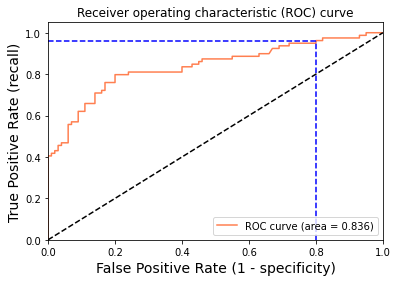

In [115]:
plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [117]:
# Проверим характеристики модели KNeighborsClassifier.
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:, 1]
print('Train/Test split results:')
print(knn.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred_knn))

Train/Test split results:
KNeighborsClassifier accuracy is 0.670


# Выводы

Изучая ноутбуки других участников соревнования я обнаружил необъятное множество вариантов и приёмов решения задачи классификации, визуализации данных. В библиотеке sklearn существуют в том числе и иструменты для выбора признаков для модели, например RFE (Recursive feature elimination). Также очень наглядным способом представления зависимостей между признаками является матрица корреляций и построенная на её основе тепловая карта.


---


Из проведенного исследования в конкретной задаче видно, что логистическая регресия при данном наборе признаков (а в других решениях существуют гораздо более изощренные способы их представления, например учитываются титулы пассажиров) показывает более высокую точность в задаче классификации. Хотя вполне очевидно, что при подборе параметров для конкретной модели (как и ожидалось, для этого существуют инструменты, GridSearchCV).